In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, fnmatch

from google.colab import files
from PIL import Image, ImageOps

from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16

In [2]:
# !files.upload()
# !ls

/bin/bash: -c: line 1: syntax error: unexpected end of file
sample_data


In [5]:
# import zipfile
# z = zipfile.ZipFile('./cityscape_data.zip', 'r')
# z.extractall()

In [6]:
# !mkdir images
# !mkdir labels
# !rm cityscape_data.zip

In [20]:
# Заархивируем и выгрузим разделенные картинки
# !tar -cvf archive.tar ./images/ ./labels/

In [4]:
# !tar -xf archive.tar

In [5]:
# path_img_train = './train/'
# path_img_val = './val/'
path_images = './images/'
path_labels = './labels/'

In [6]:
# imgs_train = os.listdir(path_img_train)
# imags_val = os.listdir(path_img_val)
imag = os.listdir(path_images)
imag_label = os.listdir(path_labels)

In [9]:
# def cut_image(path, img):
#   tmp_img = Image.open(path+img)
#   imag = tmp_img.crop((0, 0, 256, 256))
#   imag.save(path_images+img)
#   label = tmp_img.crop((256, 0, 512, 256))
#   label.save(path_labels+img)

In [11]:
# for img in imgs_train:
#   cut_image(path_img_train, img)

In [7]:
# Загружаем картинки
images = []
segments = []
for img in imag:
  images.append(image.load_img(path_images+img))
  segments.append(image.load_img(path_labels+img))

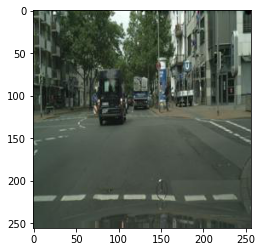

In [8]:
# Посмотрели на входные кадры

plt.imshow(images[0].convert('RGBA'))
plt.show()

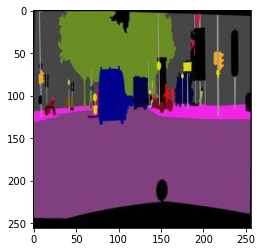

In [9]:
plt.imshow(segments[0].convert('RGBA'))
plt.show()

In [10]:
import cv2
from sklearn.cluster import KMeans
from skimage.color import rgb2lab, deltaE_cie76

In [11]:
def get_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

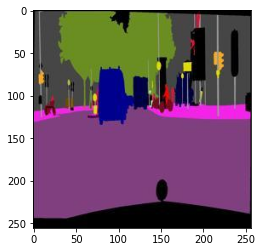

In [13]:
image_cv = get_image(path_labels+imag[0])
plt.imshow(image_cv)

In [14]:
modified_image = image_cv.reshape(image_cv.shape[0]*image_cv.shape[1], 3)

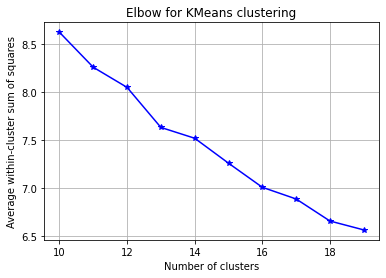

In [18]:
from scipy.spatial import distance as sci_distance
from sklearn import cluster as sk_cluster

cdata = modified_image
K = range(10, 20)
KM = (sk_cluster.KMeans(n_clusters=k).fit(cdata) for k in K)
centroids = (k.cluster_centers_ for k in KM)

D_k = (sci_distance.cdist(cdata, cent, 'euclidean') for cent in centroids)
dist = (np.min(D, axis=1) for D in D_k)
avgWithinSS = [sum(d) / cdata.shape[0] for d in dist]
plt.plot(K, avgWithinSS, 'b*-')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')
plt.show()

15799577.94383382
14555124.51810769
13327025.28258225
12305056.869732464
11555614.968207952
10858097.826963505
10409019.787250511
9874641.020857736
9417617.217324948
9046326.088072732


Text(0.5, 1.0, 'Inertia')

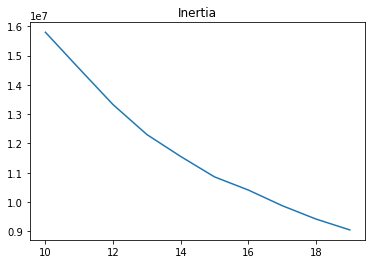

In [20]:
inertia_arr = []
for i in range(10, 20):
    temp_model = KMeans(n_clusters=i)
    temp_model.fit(modified_image)
    temp_inertia = temp_model.inertia_
    print(temp_inertia)
    inertia_arr.append(temp_inertia)

plt.plot([i for i in range(10, 20)], inertia_arr)
plt.title('Inertia')

In [21]:
clf = KMeans(n_clusters = 13)
colors = clf.fit_predict(modified_image)
print(colors)

[1 1 1 ... 1 1 1]


In [22]:
from collections import Counter
count_colors = Counter(colors)
center_colors = clf.cluster_centers_
ordered_colors = [center_colors[i] for i in count_colors.keys()]
ordered_colors

[array([2.81420145, 1.92990018, 2.7488657 ]),
 array([48.16694352, 23.25830565, 40.0589701 ]),
 array([70.78994472, 70.11231026, 68.42432219]),
 array([110.6669506 , 124.5306644 ,  75.16780239]),
 array([146.56656347, 142.58668731, 137.64396285]),
 array([106.56251477, 141.13507445,  35.07586859]),
 array([137.34357542,  28.29189944,  49.17039106]),
 array([127.66085815,  63.12766578, 126.91589807]),
 array([192.671875  ,  59.94791667, 180.05034722]),
 array([216.71311475, 186.12909836,  64.86065574]),
 array([ 6.52586207,  5.03534483, 65.24482759]),
 array([  2.94385593,   1.83262712, 138.7065678 ]),
 array([236.89923954,  40.79784537, 225.96007605])]

In [23]:
def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))
hex_colors = [RGB2HEX(ordered_colors[i]) for i in count_colors.keys()]
hex_colors

['#301728',
 '#d8ba40',
 '#020102',
 '#6e7c4b',
 '#060541',
 '#891c31',
 '#ec28e1',
 '#464644',
 '#928e89',
 '#c03bb4',
 '#6a8d23',
 '#02018a',
 '#7f3f7e']

In [24]:
rgb_colors = [ordered_colors[i] for i in count_colors.keys()]
rgb_colors

[array([48.16694352, 23.25830565, 40.0589701 ]),
 array([216.71311475, 186.12909836,  64.86065574]),
 array([2.81420145, 1.92990018, 2.7488657 ]),
 array([110.6669506 , 124.5306644 ,  75.16780239]),
 array([ 6.52586207,  5.03534483, 65.24482759]),
 array([137.34357542,  28.29189944,  49.17039106]),
 array([236.89923954,  40.79784537, 225.96007605]),
 array([70.78994472, 70.11231026, 68.42432219]),
 array([146.56656347, 142.58668731, 137.64396285]),
 array([192.671875  ,  59.94791667, 180.05034722]),
 array([106.56251477, 141.13507445,  35.07586859]),
 array([  2.94385593,   1.83262712, 138.7065678 ]),
 array([127.66085815,  63.12766578, 126.91589807])]

In [41]:
from collections import namedtuple
Point = namedtuple('Point', ('coords', 'n', 'ct'))
def get_points(img):
    points = []
    w, h = img.size
    for count, color in img.getcolors(w * h):
        points.append(Point(color, 3, count))
    return points

None


In [42]:
colors = get_points(segments[0])
print(colors)

[Point(coords=(8, 0, 160), n=3, ct=1), Point(coords=(1, 0, 192), n=3, ct=1), Point(coords=(2, 0, 128), n=3, ct=1), Point(coords=(3, 0, 0), n=3, ct=22), Point(coords=(4, 0, 128), n=3, ct=2), Point(coords=(5, 0, 144), n=3, ct=3), Point(coords=(6, 0, 192), n=3, ct=1), Point(coords=(7, 0, 112), n=3, ct=2), Point(coords=(9, 0, 128), n=3, ct=1), Point(coords=(3, 0, 128), n=3, ct=1), Point(coords=(11, 0, 128), n=3, ct=1), Point(coords=(13, 0, 144), n=3, ct=1), Point(coords=(4, 0, 160), n=3, ct=2), Point(coords=(15, 0, 112), n=3, ct=1), Point(coords=(1, 0, 160), n=3, ct=1), Point(coords=(15, 1, 16), n=3, ct=3), Point(coords=(4, 1, 144), n=3, ct=6), Point(coords=(0, 2, 161), n=3, ct=2), Point(coords=(6, 0, 0), n=3, ct=3), Point(coords=(16, 0, 144), n=3, ct=1), Point(coords=(17, 0, 144), n=3, ct=2), Point(coords=(7, 0, 176), n=3, ct=1), Point(coords=(20, 0, 224), n=3, ct=1), Point(coords=(21, 0, 128), n=3, ct=1), Point(coords=(25, 0, 112), n=3, ct=1), Point(coords=(8, 0, 128), n=3, ct=1), Point(

In [17]:
# Собираем входные примеры

img_array = []

for img in images:
  x = image.img_to_array(img)
  img_array.append(x)

xTrain_Test = np.array(img_array)

In [18]:
print(xTrain_Test.shape)

(2975, 256, 256, 3)


In [26]:
labels_array = []

for seg in segments:
  y = image.img_to_array(seg)
  labels_array.append(y)

yTrain_Test = np.array(labels_array)

In [27]:
print(yTrain_Test.shape)

(2975, 256, 256, 3)


In [21]:
# Это наша метрика на Tensorflow

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)


In [22]:
# Создаем модель

def cuttedUnet(num_classes = 14, input_shape= (256, 256, 3)):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out)

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out)

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_4_out = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # слой классификатор
    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    out=tf.layers.conv2d(y_batch_5,activation=None,filters=3,kernel_size=1,strides=1,padding='SAME')

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

In [23]:
modelC = cuttedUnet(14, (200, 600, 3))

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 600, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 200, 600, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 200, 600, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 200, 600, 64) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [25]:
N = 2000
yTrain = yTrain_Test[:N,:,:,:]
xTrain = xTrain_Test[:N,:,:,:]

yTest = yTrain_Test[N:,:,:,:]
xTest = xTrain_Test[N:,:,:,:]

In [ ]:
print(xTrain.shape)
print(yTrain.shape)

In [ ]:
print(xTest.shape)
print(yTest.shape)

In [ ]:
history = modelC.fit(xTrain, yTrain, epochs=30, batch_size=3, validation_data=(xTrain, yTrain))